## Implementación en Python del proceso de mejora de contraste:


**Explicación del código:**

* La función `enhance_contrast` toma una imagen EL como entrada y devuelve una imagen con el contraste mejorado.
* La función primero difumina la imagen con un filtro gaussiano para eliminar el ruido.
* Luego, se aplica un cierre morfológico para eliminar pequeñas imperfecciones y mejorar la uniformidad del fondo.
* La imagen original se divide por la imagen de fondo, lo que atenúa el ruido y resalta las regiones de alto contraste.
* Finalmente, se aplica la ecualización del histograma para aumentar el contraste general de la imagen.


In [1]:
# Importación de librerías

import cv2
import numpy as np

In [78]:
# Función para mejorar el contraste de una imagen EL
def enhance_contrast(image):
  """
  Mejora el contraste de una imagen EL.

  Parámetros:
    image: La imagen EL de entrada.

  Devuelve:
    La imagen con el contraste mejorado.
  """

  # Paso 1: Difuminar la imagen

  kernel_size = (5, 5)
  sigma = 1.0
  blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)

  # Paso 2: Cierre morfológico

  kernel = np.ones(( 5, 5), np.uint8)
  closed_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)

  # Paso 3: División

  bg_image = closed_image.copy()

  # Evitar la división por cero
  bg_image[bg_image == 0] = 1
  divided_image = image / bg_image

  # Paso 4: Ecualización del histograma

  enhanced_image = cv2.equalizeHist(divided_image.astype(np.uint8))

  return enhanced_image
  #return divided_image



In [93]:
def enhance_contrast(image, clip_limit=56.0, tile_grid_size=(4,4)):
    # Aplicar desenfoque gaussiano
    kernel_size = 5
    sigma = 1.0
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

    # Realizar cierre morfológico
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

    # Evitar la división por cero
    closed[closed == 0] = 1

    # Dividir la imagen original por la imagen de fondo
    division = image / closed

    # Crear objeto CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Aplicar ecualización adaptativa del histograma
    enhanced_image = clahe.apply(division.astype('uint8'))

    return enhanced_image

In [96]:
# Ejemplo de uso

# Variable para almacenar el directorio de la imagen
path_EL = "D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PVDefectDetect/Test_ImageJ/"
image = cv2.imread(path_EL + "example_10.png", cv2.IMREAD_GRAYSCALE)
#image = cv2.imread(path_EL + "MAX_070A_8v.tif", cv2.IMREAD_GRAYSCALE)
enhanced_image = enhance_contrast(image)

cv2.imshow("Imagen original", image)
cv2.imshow("Imagen con contraste mejorado", enhanced_image)
cv2.waitKey(0)

-1

## Procesamiento de una secuencia de imágenes

In [1]:
import cv2
import numpy as np
from os import listdir, path
from matplotlib import pyplot as plt

# Agregar data set
image_dataset = []
ABSOLUTE_PATH = "D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Procesamiento/7.8v_089A"
for img_path in listdir(ABSOLUTE_PATH):
    image_dataset.append(cv2.imread(path.join(ABSOLUTE_PATH, img_path), 0))
# Imprimir el número de imágenes en el dataset
print("Número de imágenes en el dataset: ", len(image_dataset))



Número de imágenes en el dataset:  51


In [4]:
# Funciones para mejorar la calidad de las imágenes

def enhance_contrast(image):
    """
    Mejora el contraste de una imagen EL.

    Parámetros:
        image: La imagen EL de entrada.
        clip_limit: Límite de contraste para la ecualización adaptativa del histograma.
        tile_grid_size: Tamaño de la cuadrícula para la ecualización adaptativa del histograma.

    Devuelve:
        La imagen con el contraste mejorado.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_image = clahe.apply(image)
    return enhanced_image

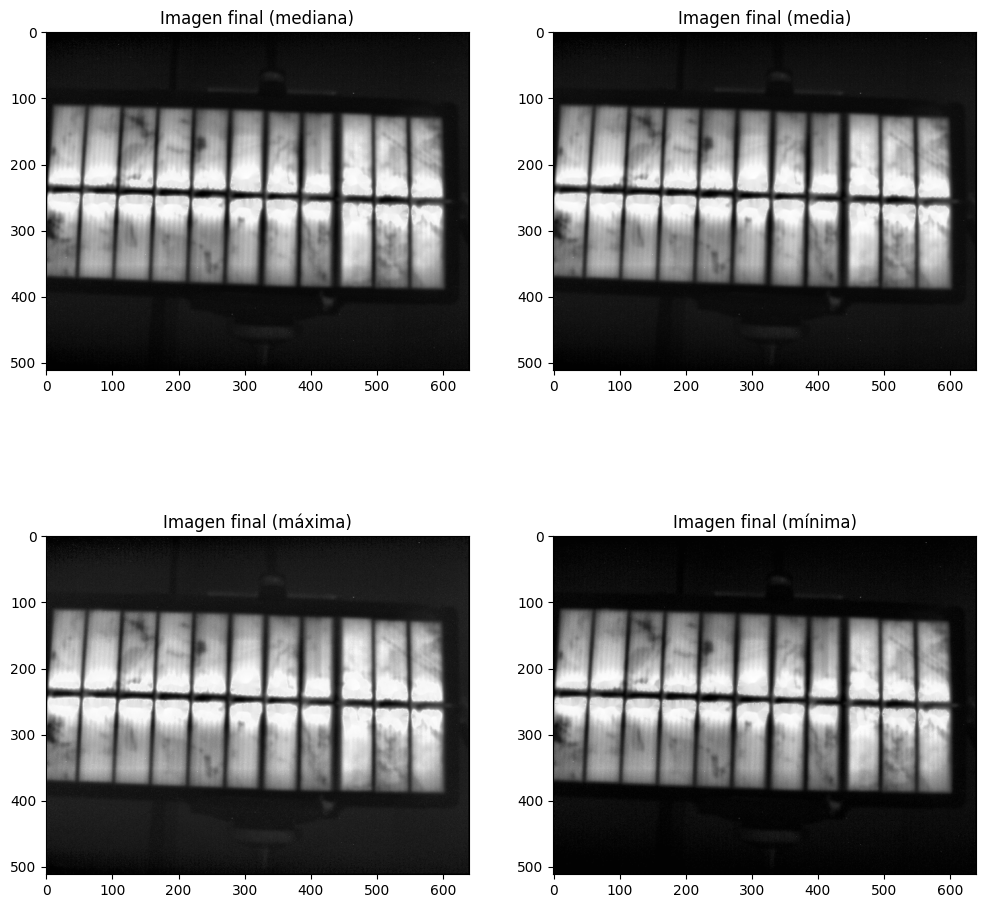

In [2]:
# Cargar las imágenes del dataset
imagenes = [image_dataset[i] for i in range(0, len(image_dataset))]
#imagenes = [cv2.imread(f'imagen{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1, 52)]

# Procesar cada imagen
for i in range(len(imagenes)):
    # Eliminar pixeles calientes
    """blur = cv2.GaussianBlur(imagenes[i], (7, 7), 0)
    _, img_th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    median = cv2.medianBlur(img_th, 5)
    imagenes[i] = cv2.subtract(imagenes[i], median)

    # Eliminar pixeles muertos
    _, img_th = cv2.threshold(imagenes[i], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    median = cv2.medianBlur(img_th, 151)
    imagenes[i] = cv2.add(imagenes[i], median)"""

    

    # Mejorar contraste
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #imagenes[i] = clahe.apply(imagenes[i])
    imagenes[i] = enhance_contrast(imagenes[i])

    # Eliminar ruido
    #imagenes[i] = cv2.fastNlMeansDenoising(imagenes[i], None, 1, 7, 21)

    # Eliminar pixeles calientes: radio de pixel = 2.0; Threshold = 50
    #ret, mask = cv2.threshold(imagenes[i], 180, 255, cv2.THRESH_BINARY)
    #imagenes[i] = cv2.inpaint(imagenes[i], mask, 2, cv2.INPAINT_TELEA)
    #blur = cv2.GaussianBlur(imagenes[i], (5, 5), 0)
    #_, img_th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #median = cv2.medianBlur(img_th, 5)
    #imagenes[i] = cv2.subtract(imagenes[i], median)

# Combinar las imágenes
imagen_final = np.median(np.array(imagenes), axis=0).astype(np.uint8)

# Establecer directorio de salida
output_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PVDefectDetect/ImagePreprocessing/Salidas/Manejo_secuencia'

# Guardar la imagen final usando la mediana de las imágenes del dataset
cv2.imwrite(path.join(output_path, 'imagen_final_mediana.png'), imagen_final)

# Guardar la imagen final usando la media de las imágenes del dataset
cv2.imwrite(path.join(output_path,'imagen_final_media.png'), np.mean(np.array(imagenes), axis=0).astype(np.uint8))

# Guardar la imagen final usando la máxima de las imágenes del dataset
cv2.imwrite(path.join(output_path,'imagen_final_maxima.png'), np.max(np.array(imagenes), axis=0).astype(np.uint8))

# Guardar la imagen final usando la mínima de las imágenes del dataset
#cv2.imwrite(path.join(output_path,'imagen_final_minima.png'), np.min(np.array(imagenes), axis=0).astype(np.uint8))

# Mostrar las imagenes finales con subplots
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Imagen final (mediana)')
plt.imshow(imagen_final, cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Imagen final (media)')
plt.imshow(np.mean(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Imagen final (máxima)')
plt.imshow(np.max(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')
plt.subplot(2, 2, 4)
plt.title('Imagen final (mínima)')
plt.imshow(np.min(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')



#cv2.imshow("Imagen final", imagen_final)
#cv2.waitKey(0)